<a href="https://colab.research.google.com/github/Jung0Jin/Pytorch_study/blob/master/4.%EC%86%8C%ED%94%84%ED%8A%B8%EB%A7%A5%EC%8A%A4%ED%9A%8C%EA%B7%80%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4.소프트맥스회귀활용

공부한 소프트맥스 회귀를 활용해보자. 캐글 타이타닉 데이터셋이다.

##4.1 데이터 다운로드

아래 링크를 클릭하면 구글 드라이브에 저장된 캐글 타이타닉 데이터가 있다. 눌러서 다운로드 받으면 된다.

출처 : https://www.kaggle.com/c/titanic/data

https://drive.google.com/open?id=1nd61rKLxciwrFHahU1PJORQQK0eIfbUg # train.csv

train 데이터로만 하고 클래스 값이 3가지인 Pclass를 타겟 데이터로 두고 분석을 해보자

##4.2 데이터 불러오기

*   데이터 설명

> The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features. 

> The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

*   특징 데이터 (11개)

> PassengerId : 승객 Id

> Pclass : 티켓 클래스 1st=1, 2nd=2, 3rd=3

> Name : 승객 이름

>	Sex : 승객 성별

>	Age : 승객 나이

>	SibSp : 함께 탑승한 형제 / 자매의 수

>	Parch : 함께 탑승한 부모 / 자식의 수

>	Ticket : 티켓 번호

>	Fare : 운임료

> Cabin : 선실 번호	

> Embarked : 승선한 항구 이름 , C = Cherbourg, Q = Queenstown, S = Southampton

> Survived : 생존했으면 1, 아니면 0

* 타겟 데이터 (1개)

> Pclass : 티켓 클래스 1st=1, 2nd=2, 3rd=3


In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [81]:
train = pd.read_csv('/content/drive/My Drive/데이터/캐글 타이타닉 데이터/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
print(train.shape)

(891, 12)


##4.3 데이터 전처리

데이터 전처리는 저번에 했다. 

(https://github.com/Jung0Jin/Pytorch_study/blob/master/3.%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1%ED%9A%8C%EA%B7%80%ED%99%9C%EC%9A%A9.ipynb)

이번에는 Pclass 데이터를 타겟 데이터로, Survived 데이터를 특징 데이터로 바꾸자.

In [83]:
train['Initial'] = 0
for i in train:
  train['Initial'] = train.Name.str.extract('([A-Za-z]+)\.') #정규표현식 [A-Za-z]대문자소문자 W. .으로 끝나는 것들

train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                         ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
                         inplace=True)

train.loc[(train.Age.isnull())&(train.Initial=='Mr'),'Age']=33
train.loc[(train.Age.isnull())&(train.Initial=='Mrs'),'Age']=36
train.loc[(train.Age.isnull())&(train.Initial=='Master'),'Age']=5
train.loc[(train.Age.isnull())&(train.Initial=='Miss'),'Age']=22
train.loc[(train.Age.isnull())&(train.Initial=='Other'),'Age']=46

train.Embarked.fillna('S', inplace=True)

train['Age_band']=0
train.loc[train['Age']<=16,'Age_band']=0
train.loc[(train['Age']>16)&(train['Age']<=32),'Age_band']=1
train.loc[(train['Age']>32)&(train['Age']<=48),'Age_band']=2
train.loc[(train['Age']>48)&(train['Age']<=64),'Age_band']=3
train.loc[train['Age']>64,'Age_band']=4

train['Family_Size']=0
train['Family_Size']=train['Parch']+train['SibSp'] #family size
train['Alone']=0
train.loc[train.Family_Size==0,'Alone']=1 #Alone

train['Fare_Range']=pd.qcut(train['Fare'],4)

train['Fare_cat']=0
train.loc[train['Fare']<=7.91,'Fare_cat']=0
train.loc[(train['Fare']>7.91)&(train['Fare']<=14.454),'Fare_cat']=1
train.loc[(train['Fare']>14.454)&(train['Fare']<=31),'Fare_cat']=2
train.loc[(train['Fare']>31)&(train['Fare']<=513),'Fare_cat']=3

train['Sex'].replace(['male','female'],[0,1],inplace=True)
train['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
train['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

train.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)

train.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Initial,Age_band,Family_Size,Alone,Fare_cat
0,0,3,0,1,0,0,0,1,1,0,0
1,1,1,1,1,0,1,1,2,1,0,3
2,1,3,1,0,0,0,2,1,0,1,1
3,1,1,1,1,0,0,1,2,1,0,3
4,0,3,0,0,0,0,0,2,0,1,1


In [84]:
# 모델에 넣을 특성들을 표준화를 시켜주자.
x_temp = train.drop(['Pclass'], axis=1) # 타겟 데이터는 Pclass이다.
x_temp = x_temp.apply(lambda x: (x - x.mean()) / x.std())
x_temp

,Survived,Sex,SibSp,Parch,Embarked,Initial,Age_band,Family_Size,Alone,Fare_cat
0,-0.788829,-0.737281,0.432550,-0.473408,-0.568518,-0.733692,-0.522280,0.059127,-1.230954,-1.346021
1,1.266279,1.354813,0.432550,-0.473408,1.004617,0.264353,0.664842,0.059127,-1.230954,1.336987
2,1.266279,1.354813,-0.474279,-0.473408,-0.568518,1.262398,-0.522280,-0.560660,0.811467,-0.451685
3,1.266279,1.354813,0.432550,-0.473408,-0.568518,0.264353,0.664842,0.059127,-1.230954,1.336987
4,-0.788829,-0.737281,-0.474279,-0.473408,-0.568518,-0.733692,0.664842,-0.560660,0.811467,-0.451685
...,...,...,...,...,...,...,...,...,...,...
886,-0.788829,-0.737281,-0.474279,-0.473408,-0.568518,3.258488,-0.522280,-0.560660,0.811467,-0.451685
887,1.266279,1.354813,-0.474279,-0.473408,-0.568518,1.262398,-0.522280,-0.560660,0.811467,0.442651
888,-0.788829,1.354813,0.432550,2.007806,-0.568518,1.262398,-0.522280,1.298700,-1.230954,0.442651
889,1.266279,-0.737281,-0.474279,-0.473408,1.004617,-0.733692,-0.522280,-0.560660,0.811467,0.442651


In [85]:
# 데이터프레임 형식은 텐서로 못 바꾼다. 어레이로 만들어 주자.
x = x_temp.values 
y = train[['Pclass']].values

print(x.shape, y.shape)

(891, 10) (891, 1)


##4.4 커스텀 데이터셋 만들기

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [0]:
class MyDataset(Dataset):
  #데이터셋의 전처리를 해주는 부분
  def __init__(self):
    self.x_data = torch.FloatTensor(x)
    self.y_data = torch.LongTensor(y-1) # 이전과 다른 부분 1. Long 타입을 쓴다. 2. y를 넣으면 1,2,3값이 들어가는데 IndexError 뜬다.
    
  #데이터셋의 길이, 즉 총 샘플의 수를 적어주는 부분
  def __len__(self):
    return len(self.x_data)
  
  #데이터셋에서 특정 1개의 샘플을 가져오는 함수
  def __getitem__(self, idx):
    x = self.x_data[idx]
    y = self.y_data[idx]
    return x, y

In [0]:
dataset = MyDataset()

In [89]:
# train set 와 validation set로 나누는 비율 정하기

train_val_ratio = 0.8
train_size = int(len(dataset) * train_val_ratio)
val_size = len(dataset) - train_size
print(train_size, val_size)

# train set와 validation set로 나누자

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

712 179
712 179


In [0]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=64,
                          shuffle=True,
                          drop_last=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset))

##4.5 모델 학습하기

In [0]:
class SoftmaxClassifierModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(10, 3)

  def forward(self, x):
    return self.linear(x)

In [0]:
model = SoftmaxClassifierModel()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [93]:
nb_epochs = 1500
train_losses = []
val_losses = []

for epoch in range(nb_epochs+1):
  train_cost_avg = 0
  """
  나는 한 epoch 당 cost를 알고 싶다.(712개로 한 바퀴 돌렸을 때의 cost) 
  근데 여기서 cost는 batch 마다 나온다. (한 배치인 64를 돌렸을 때의 cost) 
  그래서 각 배치에서의 cost를 모두 더 한후 batch의 수 만큼 나눠 평균을 구할거다.
  """
  num_batch = len(train_loader) # 712개를 64로 나누니 11개가 나오고 나머지는 drop_last로 버렸다

  for x_train, y_train in train_loader:
    y_train = y_train.squeeze(1) # 2차원을 1차원으로 바꾸자

    # H(x) 계산
    hypothesis = model(x_train)

    # train_cost 계산
    train_cost = criterion(hypothesis, y_train)

    # train_cost로 H(x) 개선
    optimizer.zero_grad()
    train_cost.backward()
    optimizer.step()

    train_cost_avg += train_cost / num_batch
  train_losses.append(train_cost_avg.item())
    
  if epoch % (nb_epochs/10) == 0:
    print(f'Epoch : {epoch}/{nb_epochs}')
    print(f'Train Cost : {train_cost_avg.item()}')

  for x_val, y_val in val_loader:
    y_val = y_val.squeeze(1) # 2차원을 1차원으로 바꾸자

    # 학습한 model로 prediction을 해보자
    prediction = model(x_val) 
    val_cost = criterion(prediction, y_val)
    val_losses.append(val_cost.item())
    
  if epoch % (nb_epochs/10) == 0:
    print(f'Validation Cost : {val_cost.item()}')
    print('-'*50)

correct_prediction = torch.argmax(prediction, dim=1) == y_val # 실제값과 일치하는 경우만 True로 간주
accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
print(f'Accuracy : {accuracy * 100}%')

Epoch : 0/1500
Train Cost : 1.095534086227417
Validation Cost : 1.0409722328186035
--------------------------------------------------
Epoch : 150/1500
Train Cost : 0.8179840445518494
Validation Cost : 0.8179886341094971
--------------------------------------------------
Epoch : 300/1500
Train Cost : 0.7150791883468628
Validation Cost : 0.7318548560142517
--------------------------------------------------
Epoch : 450/1500
Train Cost : 0.664397120475769
Validation Cost : 0.6904929876327515
--------------------------------------------------
Epoch : 600/1500
Train Cost : 0.6368412375450134
Validation Cost : 0.6666018962860107
--------------------------------------------------
Epoch : 750/1500
Train Cost : 0.6190136075019836
Validation Cost : 0.6508075594902039
--------------------------------------------------
Epoch : 900/1500
Train Cost : 0.6074761748313904
Validation Cost : 0.6394428610801697
--------------------------------------------------
Epoch : 1050/1500
Train Cost : 0.596167683601

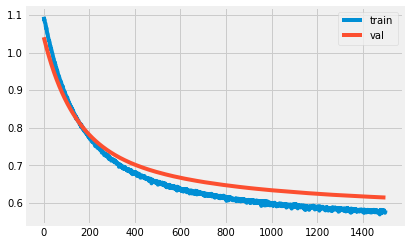

In [94]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()
plt.show()

##4.6 랜덤포레스트랑 비교하기

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.02, random_state=42)

from sklearn.ensemble import  RandomForestClassifier

model_forest = RandomForestClassifier(random_state=42)
model_forest.fit(x_train,y_train)

prediction = model_forest.predict(x_val)

from sklearn import metrics
acc_forest = metrics.accuracy_score(y_val, prediction)

In [96]:
print(f'acc_forest : {acc_forest}, acc_mymodel : {accuracy}')

acc_forest : 0.7222222222222222, acc_mymodel : 0.7262569832402235
